# kcsd-python package tutorial

In this tutorial we will cover 3 broad topics, we start with idea regular electrode configuration, where we place a known test source to compute the potentials at the electode locations and then use these potentials to perfor the kcsd estimation (Basic features). In the second part of the tutorial, we explore the case of noisy electrodes and test the robustness of the method (Noisy electrodes). In the final part we look at how the errors in the estimation depend of the sources and the electrode configuration by testing broken electrodes (Broken electrodes).

## Basic features
In this tutorial we will cover the simplest case to test the kCSD method in 2 dimensions. The following steps, will take us through this.
1. Define a region of interest - a 2 dimensional space as the test bench
2. Using predefined test functions for the current sources, place a current source in this region
3. Place an electrode configuration in the the region of interest
4. Assuming ideal electrodes, obtain the potential generated at the electrodes due the the current sources
5. From these potentials, the electrode locations and using the default conditions obtain the current source density estimate
6. Perform cross validation to make sure the the estimate is not overfit

### Region of interest

In [1]:
%matplotlib inline
import numpy as np
csd_at = np.mgrid[0.:1.:100j,                                                                                                                                                           
                  0.:1.:100j]
csd_x, csd_y = csd_at

We use the `numpy` python library, and define a 2 dimensional space using the `mgrid` function. We define the region of interest between `0` and `1` in the `xy` plane, with a resolution of `100` points in each dimension (as indicated by `100j`). The units we will assume are in $mm$. The first line starting with the `%` is to ensure the plots using this tutorial are displayed correctly.

### Predefined current sources for testing

In [2]:
from kcsd import csd_profile as CSD
CSD_PROFILE = CSD.gauss_2d_small
true_csd = CSD_PROFILE(csd_at, seed=15) 

The `kcsd` library provides some test sources that can be generated on demand. This can be imported from the `csd_profile` module. This module contains some predefined current source generating functions which can be used as test sources. In this tutorial, we will use the `gauss_2d_small` function to generate a 2 dimensional gaussian small sources. The other option for the 2 dimensional sources is the `gauss_2d_large`. In order to generate the exact same source after each run, we must invoke this function using the same `seed` variable. For the sake of simplicity, these current sources are static and do not change with time. 
***
To visualize the current sources, we can display the current source density as a heatmap. Also note that changing the `seed`, or the source type to `gauss_2d_large`, changes the type of the current sources generated. The code below displays this test source as what we refer to as the True CSD. For convinience let us define this as a function `make_plot`.

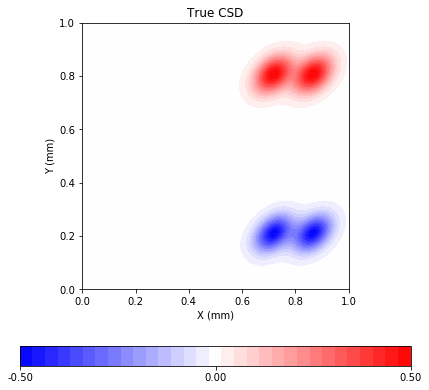

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def make_plot(xx, yy, zz, title='True CSD', cmap=cm.bwr):
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    t_max = np.max(np.abs(zz))
    levels = np.linspace(-1 * t_max, t_max, 32)
    im = ax.contourf(xx, yy, zz, levels=levels, cmap=cmap)
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title(title)
    ticks = np.linspace(-1 * t_max, t_max, 3, endpoint=True)
    plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)
    return ax
make_plot(csd_x, csd_y, true_csd, title='True CSD', cmap=cm.bwr)

### Place electrodes

In [4]:
ele_x, ele_y = np.mgrid[0.05: 0.95: 10j,
                        0.05: 0.95: 10j]
ele_pos = np.vstack((ele_x.flatten(), ele_y.flatten())).T

We now chose the positions of the electrodes within the region of interest. Once again, we obtain their positions using the `mgrid` function, and place them between `0.05` $mm$ and `0.95` $mm$ of the region of interest, with a resolution of `10` (as indicated by `10j`) in each dimensions, totalling to `100` electrodes. Notice that the electrodes do not span the entire region of interest. Although this example illustrates regular spaced, the method does not require this and can handle any arbitrary distribution of electrodes.

### Compute potentials generated

In [5]:
from scipy.integrate import simps

def integrate_2d(csd_at, true_csd, ele_pos, h, csd_lims):
    csd_x, csd_y = csd_at
    xlin = csd_lims[0]                                                                                                                                                                                      
    ylin = csd_lims[1]                                                                                                                                                                                      
    Ny = ylin.shape[0]                                                                                                                                                                                      
    m = np.sqrt((ele_pos[0] - csd_x)**2 + (ele_pos[1] - csd_y)**2)                                                                                                           
    m[m < 0.0000001] = 0.0000001
    y = np.arcsinh(2 * h / m) * true_csd
    integral_1D = np.zeros(Ny)                                        
    for i in range(Ny):                                                  
        integral_1D[i] = simps(y[:, i], ylin)
    integral = simps(integral_1D, xlin)
    return integral

def forward_method(ele_pos, csd_at, true_csd):
    pots = np.zeros(ele_pos.shape[0])
    xlin = csd_at[0, :, 0]
    ylin = csd_at[1, 0, :]
    h = 50.  # distance between the electrode plane and the CSD plane
    sigma = 1.0 # S/m
    for ii in range(ele_pos.shape[0]):                                                                                                                                                                      
        pots[ii] = integrate_2d(csd_at, true_csd,                                                                                                                                                         
                                [ele_pos[ii][0], ele_pos[ii][1]], h,                                                                                                                                      
                                [xlin, ylin])
    pots /= 2 * np.pi * sigma
    return pots

pots = forward_method(ele_pos, csd_at, true_csd)

At the given electrode positions, we need to evaluate the potential generated due to the current sources that were placed in step 2, this is given by the function `forward_method`. We make some assumptions regarding the location of the sources with respect to the electrode positions, given by the variable `h`. We aslo assume that the medium in between is infinite homogeneous medium whose conductivity is given by variable `sigma` and equals `1` $S/m$. We utilize the `scipy` library's `simps` function to integrate the current sources in the two dimensions to obtain the potentials -`pots`, at the electrode positions. We also assume that the electrodes are ideal, point sized and noise free.
***
To visulize the potentials, we use the potentials obtained at the electrodes positions (100 of them), and use the  `scipy` libraries `interpolate.griddata` function to extract the potentials in the plane of electrodes. While this is solely "see" the potentials. The kcsd method does only utilized the potentials recorded at the electrode postions as we shall see in the next step. We shall display this intepolated potential using a different heatmap to emphasize that the current sources and the potentials are two distinct quantities. We can also display the electrodes as a scattered points on this plot.

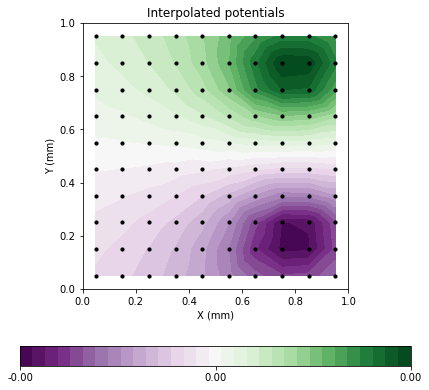

In [6]:
from scipy.interpolate import griddata

def grid(x, y, z):                                                                                                                                                                    
    x = x.flatten()                                                                                                                                                                                             
    y = y.flatten()                                                                                                                                                                                             
    z = z.flatten()                                                                                                                                                                                             
    xi, yi = np.mgrid[min(x):max(x):np.complex(0, 100),                                                                                                                                                        
                      min(y):max(y):np.complex(0, 100)]                                                                                                                                                        
    zi = griddata((x, y), z, (xi, yi), method='linear')                                                                                                                                                         
    return xi, yi, zi

pot_X, pot_Y, pot_Z = grid(ele_pos[:, 0], ele_pos[:, 1], pots)
ax = make_plot(pot_X, pot_Y, pot_Z, title='Interpolated potentials', cmap=cm.PRGn)
ax.scatter(ele_pos[:, 0], ele_pos[:, 1], 10, c='k')

### kCSD method

In [7]:
from kcsd import KCSD2D

def do_kcsd(ele_pos, pots):
    h = 50.  # distance between the electrode plane and the CSD plane
    sigma = 1.0 # S/m
    pots = pots.reshape((len(ele_pos), 1)) # first time point 
    k = KCSD2D(ele_pos, pots, h=h, sigma=sigma,                                                                                                                                                       
               xmin=0.0, xmax=1.0,
               ymin=0.0, ymax=1.0,
               n_src_init=1000, src_type='gauss', R_init=1.)
    return k

k = do_kcsd(ele_pos, pots)
est_csd = k.values('CSD')

In this step, we import from the `kcsd` library, the relevant method `KCSD2D` to estimate the current source density. For convinience we place this inside a function called `do_kcsd`. Inside this we perform the following steps.
* We define the forward model of the kcsd method with the `h` and `sigma` parameters 
* We reshape the potentials so that they correspond to the first time point of the recording. In an actual recording this would be of the shape $N_{ele} \times N_{time}$, where $N_{ele}$ is the number of electrodes and $N_{time}$ is the total number of time points of recording. 
* Next, we invoke the `KCSD2D` class with the relevant parameters. The only necessary parameters that need to passed to this class are the positions of the electrodes - `ele_pos` and the potentials they see - `pots`.
* Additionally, we can also "tell" the method regarding some of the assumptions to take for the forward method by passing the variables `h` and `sigma`. 
* Similarly, that we expect the sources to lie between `xmin`,`xmax` and `ymin`,`ymax`. We also impose to try to `1000` basis functions of the type `gauss`, and to guess the initial size of the gaussian basis source `R_init` to be `1`.
* In the final step we obtain the estimated `CSD` by asking the method for their value and storing it, as `est_csd`.
***
We once again can visualize the estimated current source density my making a heatmap of this estimation. This must be compared to the True CSD obtained at the end of step 2. However we notice that the estimation does not resemble the current source which we are testing. Perhaps the parameters that we are passing were a bad choice. For these reasons we perform cross validation to ensure that the estimate is not being overfit. 

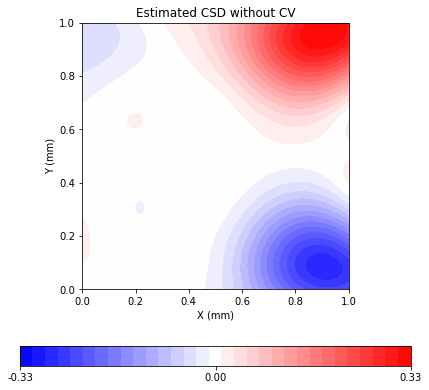

In [8]:
make_plot(k.estm_x, k.estm_y, est_csd[:, :, 0], 
          title='Estimated CSD without CV', cmap=cm.bwr) # First time point

### Cross validation

In [9]:
k.cross_validate(Rs=np.linspace(0.01, 0.15, 15))
est_csd = k.values('CSD')

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.02
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.04
Cross validating R (all lambda) : 0.05
Cross validating R (all lambda) : 0.06
Cross validating R (all lambda) : 0.07
Cross validating R (all lambda) : 0.08
Cross validating R (all lambda) : 0.09
Cross validating R (all lambda) : 0.1
Cross validating R (all lambda) : 0.11
Cross validating R (all lambda) : 0.12
Cross validating R (all lambda) : 0.13
Cross validating R (all lambda) : 0.14
Cross validating R (all lambda) : 0.15
R, lambda : 0.11 1.46779926762e-06


The cross validation step is a single line command that automatically perform cross validation using leave one out approach of the electrodes. Here the crossvalidation is performed for a range of `R` values which gives the size of the gaussian basis function, and the regularization parameter $\lambda$ values. At the end of the this step, we would obtain the optimal parameters that would correct for any overfitting. The outputs the progress of the crossvalidation step and displays the optimal candidates in the last line. An alternative way of finding these optimal parameters would be to utilize the L-curve method.
***
Once again, we can visualise the current source density estimation after cross validation step as a heat map. We find that the estimation of the current sources resembles the True CSD.

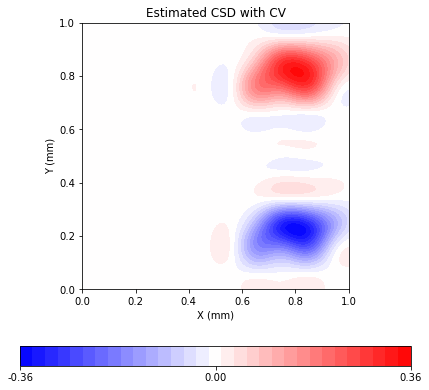

In [10]:
make_plot(k.estm_x, k.estm_y, est_csd[:, :, 0], 
          title='Estimated CSD with CV', cmap=cm.bwr) # First time point

## Noisy electrodes

Untill now, we used electrodes that which are ideal and noise free. However in experiments are noisy. This could be due to the limitation of the recording setup or other reasons. In this tutorial we will see how the kcsd estimation is affected due to noise level.
1. Reconstruction quality measure
2. Definition of a noise level added to the potentials
3. Error in the reconstruction with changing noise level

### Reconstruction quality measure

In [11]:
def point_errors(true_csd, est_csd):
    true_csd_r = true_csd.reshape(true_csd.size, 1)
    est_csd_r = est_csd.reshape(est_csd.size, 1)
    epsilon = np.linalg.norm(true_csd_r)/np.max(abs(true_csd_r))
    err_r = abs(est_csd_r/(np.linalg.norm(est_csd_r)) -
              true_csd_r/(np.linalg.norm(true_csd_r)))
    err_r *= epsilon
    err = err_r.reshape(true_csd.shape)
    return err

error_ideal = point_errors(true_csd, est_csd)

In order to assess the estimation quality we can measure the point wise difference between the true sources and the reconstructed sources from the kcsd. We define a function `point_errors` which takes the true_csd and the estimated_csd as the inputs, normalizes them individually, and computes the Frobenius norm of their difference.
***
We can then use the plotting function as we did earlier, except we will use greyscale colormap to display the intensity of the reconstruction error. And just as before, for the sake of convenience we shall define the plotting as a function called `make_error_plot`. 

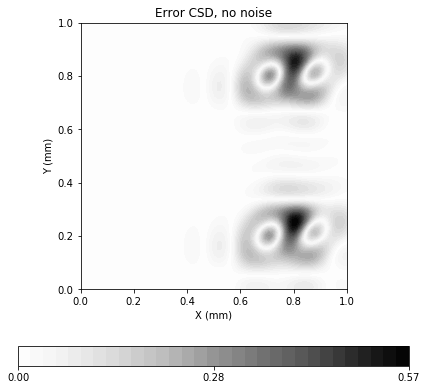

In [12]:
def make_error_plot(xx, yy, error, title='Error CSD'):
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    t_max = np.max(np.abs(error))
    levels = np.linspace(0, t_max, 32)
    im = ax.contourf(xx, yy, error, levels=levels, cmap=cm.Greys)
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title(title)
    ticks = np.linspace(0, t_max, 3, endpoint=True)
    plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)
    return ax
    
make_error_plot(k.estm_x, k.estm_y, error_ideal, title='Error CSD, no noise')

### Noise definition

In [13]:
def add_noise(pots, noise_level=0, noise_seed=23):
    rstate = np.random.RandomState(noise_seed)
    noise = noise_level*0.01*rstate.normal(np.mean(pots), 
                                           np.std(pots), 
                                           size=(len(pots), 1))
    return pots + noise.reshape(pots.shape)

pots_noise = add_noise(pots, noise_level=15, noise_seed=23)

We would like to artificially add noise to the exisiting recorded potenials, but at the same time we would like to be able to consistently look at the same noise when we inspect the reconstruction later, this would be possible by seeding the randon generator. We define the noise as a normal distribution with the mean and standard devision same as the recorded potentials. Writing this as function called `add_noise` enables us to reuse it.

### Reconstruction with noise

In [14]:
k_noise = do_kcsd(ele_pos, pots_noise)
k_noise.cross_validate(Rs=np.linspace(0.01, 0.15, 15))
estm_csd_noise = k_noise.values('CSD')
error_noise = point_errors(true_csd, estm_csd_noise)

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.02
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.04
Cross validating R (all lambda) : 0.05
Cross validating R (all lambda) : 0.06
Cross validating R (all lambda) : 0.07
Cross validating R (all lambda) : 0.08
Cross validating R (all lambda) : 0.09
Cross validating R (all lambda) : 0.1
Cross validating R (all lambda) : 0.11
Cross validating R (all lambda) : 0.12
Cross validating R (all lambda) : 0.13
Cross validating R (all lambda) : 0.14
Cross validating R (all lambda) : 0.15
R, lambda : 0.01 0.00110069417125


Lets, put this tutorial together, obtain the noise for a given noise level (choose between 0 and 100), and then use the obtained potentials to perform the CSD estimation. We can then use the error plots to compare the reconstruction  with the True CSD. Notice that the ideal parameters obtained after addtion of the noise need not be same the the one obtained when the potentials are without any noise addition.
***
We can display this error again with the plotting function which we defined earlier. Changing the `noise_level` and the `noise_seed` would change the reconstruction output. Also changing the True CSD type to a `gauss_2d_large` or changing `csd_seed`. So, the reconstruction errors depend on the location, type of the sources and the noises being added, which is expected and is mitigated by the crossvalidation.

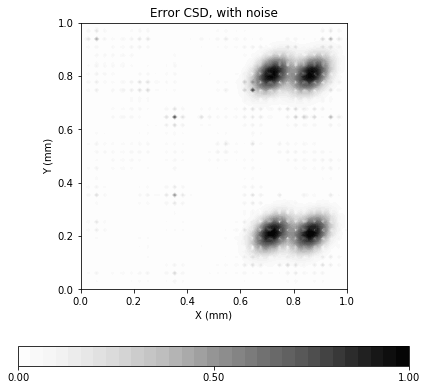

In [15]:
make_error_plot(k_noise.estm_x, k_noise.estm_y, error_noise, 
                title='Error CSD, with noise')

## Broken electrodes
In some setups, not all electrodes are used all the time. This can be because some of them are being used as stimulation electrodes and in some cases these electrodes are broken or too noisy to be included. In some other cases, the electrodes can be irregularly placed. In this tutorial we shall see how to handle such cases.
1. Remove broken electrodes, those which are used in stimulation
2. Error in the estimation for a given source, with broken electrodes
3. Average error across many sources, with broken electrodes

### Remove broken electrodes

In [16]:
def remove_electrodes(ele_pos, num_broken, broken_seed=42):                                                                                                                                 
    rstate = np.random.RandomState(broken_seed)  # just a random seed                                                                                                                                        
    rmv = rstate.choice(ele_pos.shape[0], num_broken, replace=False)                                                                                                                                
    ele_pos = np.delete(ele_pos, rmv, 0)
    return ele_pos

ele_pos_new = remove_electrodes(ele_pos, 5)  # Discard 5 electrodes of 100

In order to simulate the effect of broken electrodes or discard the ones used in stimulation protocols, we can write a function `remove_electrodes` that takes all the default electrode positions and a number of electrodes that need to be removed. In this case, we remove the electrodes in random. Like we did previously, to enable repeatability we pass a `broken_seed` variable, such that at each subsequent runs it is the same set of electrodes that are discarded. By changing this seed, a different set of electrodes can be discarded.

### Error in estimation, with broken electrodes

In [17]:
def calculate_error(csd_seed, ele_pos):
    true_csd = CSD_PROFILE(csd_at, seed=csd_seed) 
    pots = forward_method(ele_pos, csd_at, true_csd)
    k = do_kcsd(ele_pos, pots)
    k.cross_validate(Rs=np.linspace(0.01, 0.15, 15))
    err = point_errors(true_csd, k.values('CSD'))
    return k, err

k, err = calculate_error(csd_seed=15, ele_pos=ele_pos_new)

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.02
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.04
Cross validating R (all lambda) : 0.05
Cross validating R (all lambda) : 0.06
Cross validating R (all lambda) : 0.07
Cross validating R (all lambda) : 0.08
Cross validating R (all lambda) : 0.09
Cross validating R (all lambda) : 0.1
Cross validating R (all lambda) : 0.11
Cross validating R (all lambda) : 0.12
Cross validating R (all lambda) : 0.13
Cross validating R (all lambda) : 0.14
Cross validating R (all lambda) : 0.15
R, lambda : 0.14 1.33352143216e-05


We write all the steps into a fuction `calculate_error` which takes a `csd_seed` as an input, all the electrode positions `ele_pos` as the electrode locations in the setup. It computes the True csd for a `gauss_2d_small` type source, computes the potentials generated at these valid electrode locations, computes the kcsd, and also computes the error in the estimation from the true csd.
***
Below, we use the function to display a heatmap in grey scale of the error in the kcsd estimation from the true sources. We also display the electrodes and are being considered in the kcsd method. 

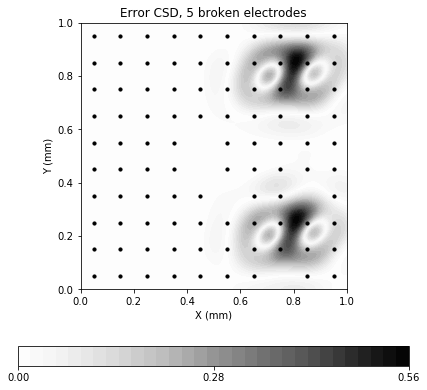

In [18]:
ax = make_error_plot(k.estm_x, k.estm_y, err, 
                     title='Error CSD, 5 broken electrodes')
ax.scatter(ele_pos_new[:, 0], ele_pos_new[:, 1], 10, c='k')

### Average error for multiple sources

In [19]:
seed_list = range(15, 17)
error_list = []
for csd_seed in seed_list:
    k, err = calculate_error(csd_seed=csd_seed, ele_pos=ele_pos_new)
    error_list.append(err)
avg_error = sum(error_list) / len(error_list)

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.02
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.04
Cross validating R (all lambda) : 0.05
Cross validating R (all lambda) : 0.06
Cross validating R (all lambda) : 0.07
Cross validating R (all lambda) : 0.08
Cross validating R (all lambda) : 0.09
Cross validating R (all lambda) : 0.1
Cross validating R (all lambda) : 0.11
Cross validating R (all lambda) : 0.12
Cross validating R (all lambda) : 0.13
Cross validating R (all lambda) : 0.14
Cross validating R (all lambda) : 0.15
R, lambda : 0.14 1.33352143216e-05
No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.02
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.04
Cross validating R (all lambda) : 0.05
Cross validating R (all lambda) : 0.06
Cross validating R (all lambda) : 0.07
Cross validating R (all lambda) : 0.08
Cross

As we observe that the error in the estimation is closely tied to the current source that is being used to test. We can compute the average error across multiple source seeds, and this would give us an overall picture of the estimation capabilities of the kcsd method. For instance we show for 2 seeds here, but in principle any number of sources may be tested. The more the tested sources, the better our understanding of the setup. This step is computationally expensive, however this would have to be carried out only once for an electrode design configuration, ie., it depends on the electrode locations. 
***
We can then use the function we defined earlier to display the average error for the two seeds.

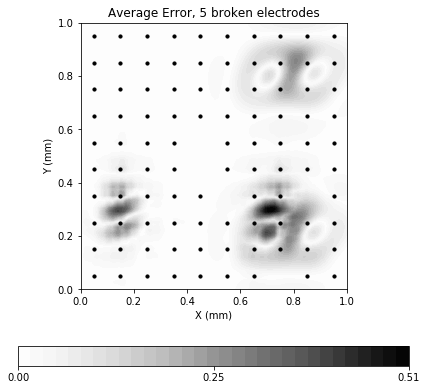

In [23]:
ax = make_error_plot(k.estm_x, k.estm_y, avg_error, 
                     title='Average Error, 5 broken electrodes')
ax.scatter(ele_pos_new[:, 0], ele_pos_new[:, 1], 10, c='k')